In [1]:
import cv2 

img = cv2.imread(r'C:\Users\rival\Documents\IA\Inteligencia-Artificial\CNN-Sports\sportimages\basket\basket2_0001.jpg')
print(img.shape[0], img.shape[1], img.shape[2], len(img.shape))

21 28 3 3


# Convolutional Neural Networks

# Importar Librerías

In [2]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.optimizers import SGD
from keras.layers import LeakyReLU

# Cargar set de Imágenes

In [ ]:
dirname = os.path.join(os.getcwd(), r'\sportimages')
imgpath = dirname + os.sep

images = []
directories = []
dircount = []

print("leyendo imagenes de", imgpath)

for root, _, filenames in os.walk(imgpath):
    count = 0
    for filename in filenames:
        if re.search(r"\.(jpg|jpeg|png|bmp|tiff)$", filename, re.IGNORECASE):
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            if len(image.shape) == 3:
                images.append(image)
            count += 1
            print(f"Leyendo... {len(images)}", end="\r")

    if count > 0:  # Only add directories that have images
        directories.append(root)
        dircount.append(count)
        print(root, count)

print('Directorios leidos:', len(directories))
print("Imagenes en cada directorio", dircount)
print('Suma Total de imagenes en subdirs:', sum(dircount))

leyendo imagenes de C:\Users\rival\Documents\IA\Inteligencia-Artificial\CNN-Sports\sportimages\
C:\Users\rival\Documents\IA\Inteligencia-Artificial\CNN-Sports\sportimages\americano 9348
C:\Users\rival\Documents\IA\Inteligencia-Artificial\CNN-Sports\sportimages\basket 8823
C:\Users\rival\Documents\IA\Inteligencia-Artificial\CNN-Sports\sportimages\beisball 7752
C:\Users\rival\Documents\IA\Inteligencia-Artificial\CNN-Sports\sportimages\boxeo 7125
C:\Users\rival\Documents\IA\Inteligencia-Artificial\CNN-Sports\sportimages\ciclismo 7533
C:\Users\rival\Documents\IA\Inteligencia-Artificial\CNN-Sports\sportimages\f1 5053
C:\Users\rival\Documents\IA\Inteligencia-Artificial\CNN-Sports\sportimages\futbol 7617
C:\Users\rival\Documents\IA\Inteligencia-Artificial\CNN-Sports\sportimages\golf 9768
C:\Users\rival\Documents\IA\Inteligencia-Artificial\CNN-Sports\sportimages\natacion 5172
C:\Users\rival\Documents\IA\Inteligencia-Artificial\CNN-Sports\sportimages\tenis 8937
Directorios leidos: 10
Imagenes e

# Creamos las etiquetas

In [5]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  77128


In [6]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 americano
1 basket
2 beisball
3 boxeo
4 ciclismo
5 f1
6 futbol
7 golf
8 natacion
9 tenis


In [7]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy



# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


# Creamos Sets de Entrenamiento y Test

In [8]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (61702, 21, 28, 3) (61702,)
Testing data shape :  (15426, 21, 28, 3) (15426,)


Text(0.5, 1.0, 'Ground Truth : 6')

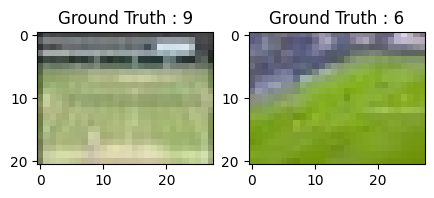

In [9]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

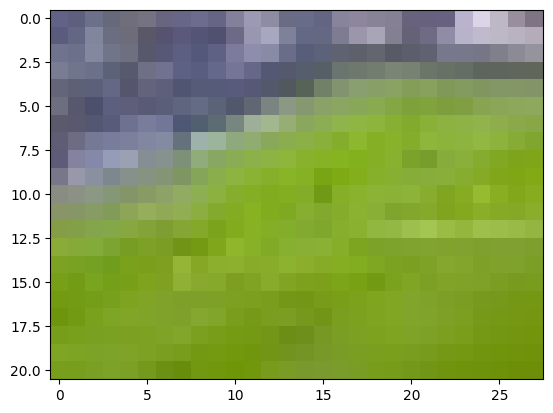

In [10]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [11]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# Creamos el Set de Entrenamiento y Validación

In [12]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [13]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(49361, 21, 28, 3) (12341, 21, 28, 3) (49361, 10) (12341, 10)


# Creamos el modelo de CNN

In [14]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 20 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size =  64 # cantidad de imágenes que se toman a la vez en memoria

In [15]:
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))


sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

C:\Users\rival\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\rival\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [16]:
sport_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 21, 28, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 21, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 11, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4928)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         157,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 158,954 (620.91 KB)

 Trainable params: 158,954 (620.91 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
sport_model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),
    metrics=['accuracy']
)

C:\Users\rival\AppData\Roaming\Python\Python313\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


# Entrenamos el modelo: Aprende a clasificar imágenes

In [18]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1583 - loss: 2.2543 - val_accuracy: 0.2420 - val_loss: 2.1480
Epoch 2/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2391 - loss: 2.1207 - val_accuracy: 0.4322 - val_loss: 1.9452
Epoch 3/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3007 - loss: 1.9738 - val_accuracy: 0.5393 - val_loss: 1.7620
Epoch 4/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3590 - loss: 1.8293 - val_accuracy: 0.5906 - val_loss: 1.5955
Epoch 5/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4097 - loss: 1.7080 - val_accuracy: 0.6277 - val_loss: 1.4486
Epoch 6/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4508 - loss: 1.5999 - val_accuracy: 0.6642 - val_loss: 1.3246
Epoch 7/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4845 - loss: 1.5067 - val_accuracy: 0.6826 - val_loss: 1.2234
Epoch 8/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5188 - loss: 1.4158 - val_accuracy: 0.

In [19]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("sport.h5")

# Evaluamos la red

In [20]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8269 - loss: 0.6602


In [21]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.6601951122283936
Test accuracy: 0.8268507719039917


In [22]:
sport_train.history

{'accuracy': [0.15830311179161072,
  0.23907537758350372,
  0.30066245794296265,
  0.35904863476753235,
  0.4096553921699524,
  0.4508012533187866,
  0.48453232645988464,
  0.5187901258468628,
  0.5451470017433167,
  0.5718279480934143,
  0.5833350419998169,
  0.6063289046287537,
  0.6193756461143494,
  0.6341848969459534,
  0.6477178335189819,
  0.6573205590248108,
  0.6679362058639526,
  0.6766475439071655,
  0.6875671148300171,
  0.6989120841026306],
 'loss': [2.2543439865112305,
  2.120654582977295,
  1.9737764596939087,
  1.8293377161026,
  1.7079665660858154,
  1.5999104976654053,
  1.5067130327224731,
  1.4157966375350952,
  1.3424921035766602,
  1.2732882499694824,
  1.2222728729248047,
  1.1736654043197632,
  1.1280608177185059,
  1.0930947065353394,
  1.0510857105255127,
  1.0258424282073975,
  0.9911187887191772,
  0.9704855680465698,
  0.9464622735977173,
  0.9190359711647034],
 'val_accuracy': [0.24195770919322968,
  0.4322178065776825,
  0.5392593741416931,
  0.5905517935

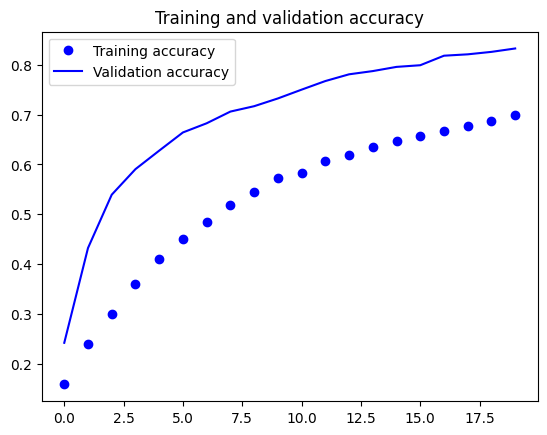

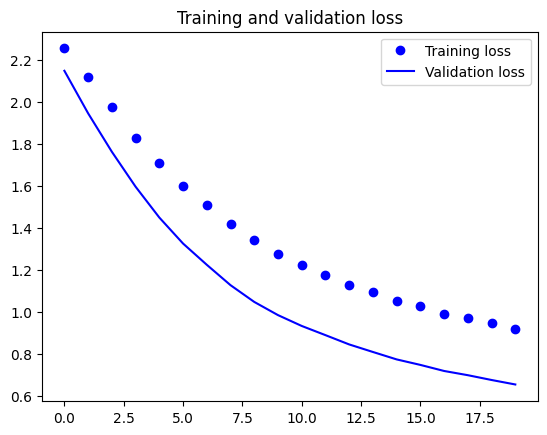

In [23]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [24]:
predicted_classes2 = sport_model.predict(test_X)

483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step


In [25]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [26]:
predicted_classes.shape, test_Y.shape

((15426,), (15426,))

# Aprendamos de los errores: Qué mejorar

Found 12755 correct labels


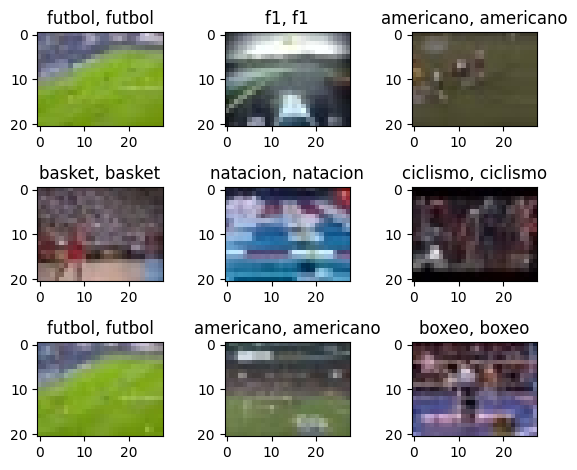

In [27]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 2671 incorrect labels


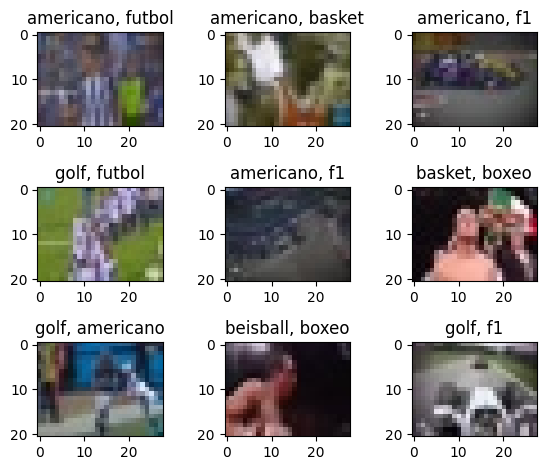

In [28]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [29]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.60      0.65      0.62      1819
     Class 1       0.83      0.89      0.86      1789
     Class 2       0.81      0.72      0.76      1520
     Class 3       0.90      0.89      0.89      1476
     Class 4       0.96      0.98      0.97      1450
     Class 5       0.84      0.35      0.49      1025
     Class 6       0.92      0.83      0.87      1517
     Class 7       0.69      0.88      0.77      1932
     Class 8       0.93      0.94      0.93      1081
     Class 9       0.97      1.00      0.98      1817

    accuracy                           0.83     15426
   macro avg       0.84      0.81      0.82     15426
weighted avg       0.83      0.83      0.82     15426



In [30]:
from skimage.transform import resize

images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
filenames = [r'C:\Users\rival\Documents\IA\Inteligencia-Artificial\CNN-Sports\test\images.jpg']

for filepath in filenames:
    image = plt.imread(filepath,0)
    image_resized = resize(image, (21, 28),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
C:\Users\rival\Documents\IA\Inteligencia-Artificial\CNN-Sports\test\images.jpg golf
